# Unit Commitment Problem

## Initialisation

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


from gurobipy import *
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import datetime
import xlrd
import pandas as pd
import math
import time
import datetime
import os
import time

In [2]:
cluster =  0
num_regions = 1
current_year = 2017

test_run = 2

t0 = time.time()




## Import Data

### Total Demand Data

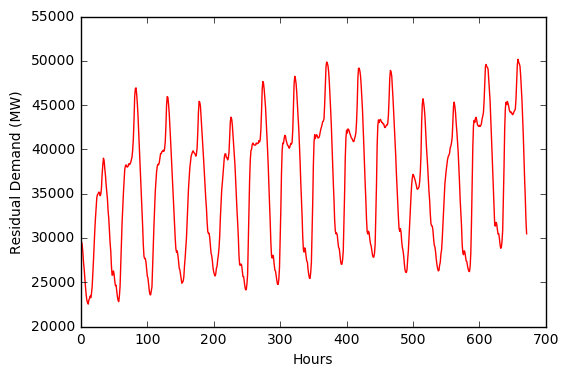

In [3]:
df_demand = pd.read_csv("TESTDATA_2WEEK.csv")

x = df_demand.columns.values

numpyMatrix = df_demand.as_matrix()

national_demand = df_demand['ND'].values
wind_gen = df_demand['EMBEDDED_WIND_GENERATION'].values
solar_gen = df_demand['EMBEDDED_SOLAR_GENERATION'].values
french_flow = df_demand['FRENCH_FLOW'].values
britned_flow = df_demand['BRITNED_FLOW'].values
moyle_flow = df_demand['MOYLE_FLOW'].values
eastwest_flow = df_demand['EAST_WEST_FLOW'].values
hours = range(len(eastwest_flow))

demand = national_demand - wind_gen - solar_gen

reserve = 0.01 * demand

plt.figure()
plt.plot(hours, demand, 'r')
plt.xlabel('Hours')
plt.ylabel('Residual Demand (MW)')
plt.show()



### Generator Data

In [4]:
df_summary = pd.read_csv("SUMMARY_170625.csv")

x = df_summary.columns.values

# Import all of the data from the df
label = df_summary['REF'].values

gen_type = df_summary['TYPE'].values

age = current_year - df_summary['AGE'].values

capacity = df_summary['TOTAL UK CAPACITY'].values

min_power_ref = df_summary['MINIMUM OUTPUT'].values
min_power = min_power_ref * capacity

max_power_out_ref = df_summary['MAXIMUM OUTPUT'].values
max_power_out = max_power_out_ref * capacity

max_ramp_up_ref = df_summary['MAX RAMP UP'].values
max_ramp_up = max_ramp_up_ref * capacity

max_ramp_down_ref = df_summary['MAX RAMP DOWN'].values
max_ramp_down = max_ramp_down_ref * capacity

startup_ramp_ref = df_summary['MAX RAMP UP'].values
startup_ramp = startup_ramp_ref * capacity

shutdown_ramp_ref = df_summary['MAX RAMP DOWN'].values
shutdown_ramp = shutdown_ramp_ref * capacity
    
initial_status = df_summary['INITIAL STATUS'].values

# Variables below are for the unit commitment constraints
prior_status_up = df_summary['PRIOR STATUS UP'].values

prior_status_down = df_summary['PRIOR STATUS DOWN'].values

up_time_prior = df_summary['PRIOR UP TIME'].values

down_time_prior = df_summary['PRIOR DOWN TIME'].values

min_up = df_summary['MIN UP TIME'].values

min_down = df_summary['MIN DOWN TIME'].values

# op_type = df_summary['OP TYPE'].values

# Set up variables for the storage
storage_capacity = df_summary['STORAGE CAPACITY'].values

batt_eff = df_summary['BATT EFFICIENCY'].values

duration = df_summary['MAX STORAGE HOURS'].values

# Read in the generator names
gen_names = numpy.unique(gen_type)
num_types = range(0,len(gen_names))

# The num_gen variable specifies the total number of generators available in the mix
num_gen = range(0, len(max_power_out))

# Number of hours
max_hours = len(hours)



### Cost Data

In [5]:
df_costs = pd.read_csv("COST_170531.csv")

x = df_costs.columns.values

# Fixed O&M - £/kW-yr
fixed_cost = df_costs['FIXED O_M'].values

# Variable O&M - £/MWh
variable_cost = df_costs['VARIABLE O_M'].values

# Capital Cost - £/kW-yr
capital_cost = df_costs['CAPITAL COST'].values

# Fixed Cost - £/kW-yr
fixed_cost_ops = df_costs['FIXED_COST OPS'].values

# Heat during start up - MBTU/start
startup_heat = df_costs['START UP HEAT'].values

# Fixed cost for startup - £/start
startup_fixed = df_costs['FIXED COST START'].values

# No load heat - MBTU/h
no_load_heat = df_costs['NO LOAD HEAT'].values

# Incremental heat rate - BTU/kWh
incr_heat_rate = df_costs['INCREMENTAL HEAT RATE'].values

# Fixed cost for shut-down - £/shut
shutdown_cost = df_costs['FIXED COST SHUT'].values

fuel_cost = df_costs['FUEL COST'].values



## Clustering

### By Type - Single Bus Model

In [6]:
# This code takes the imported data for all of the available generators, and summarises it into the clustered sets

df_cluster = pd.read_csv("REFERENCE LIST_170622.csv")
df_cluster_cost = pd.read_csv("REFERENCE_LIST_COST_170622.csv")
    
gen_label = df_cluster['TYPE'].values
num_labels = range(0,len(gen_label))

if cluster == 1:
    
    capacity_clustered = df_cluster['CAPACITY'].values
    capacity_clustered = numpy.nan_to_num(capacity_clustered)

    for i in num_gen:
        for x in num_labels:
            a = gen_type[i]
            b = gen_label[x]
            if a in b:
                capacity_clustered[x] = capacity_clustered[x] + capacity[i] 
    
    # Replace capacity with the new clustered capacity value
    capacity = capacity_clustered 

    min_power_ref = df_cluster['MINIMUM OUTPUT'].values
    min_power = min_power_ref * capacity

    max_power_out_ref = df_cluster['MAXIMUM OUTPUT'].values
    max_power_out = max_power_out_ref * capacity

    max_ramp_up_ref = df_cluster['MAX RAMP UP'].values
    max_ramp_up = max_ramp_up_ref * capacity

    max_ramp_down_ref = df_cluster['MAX RAMP DOWN'].values
    max_ramp_down = max_ramp_down_ref * capacity

    startup_ramp_ref = df_cluster['MAX RAMP UP'].values
    startup_ramp = startup_ramp_ref * capacity

    shutdown_ramp_ref = df_cluster['MAX RAMP DOWN'].values
    shutdown_ramp = shutdown_ramp_ref * capacity
    
    initial_status = df_cluster['INITIAL STATUS'].values

    # Variables below are for the unit commitment constraints
    #prior_status_up = df_cluster['PRIOR STATUS UP'].values

    prior_status_down = df_cluster['PRIOR STATUS DOWN'].values

    #up_time_prior = df_cluster['PRIOR UP TIME'].values

    down_time_prior = df_cluster['PRIOR DOWN TIME'].values

    min_up = df_cluster['MIN UP TIME'].values

    min_down = df_cluster['MIN DOWN TIME'].values

    # Set up variables for the storage
    storage_capacity = df_cluster['STORAGE CAPACITY'].values

    batt_eff = df_cluster['BATT EFFICIENCY'].values

    duration = df_cluster['MAX STORAGE HOURS'].values
    
    op_type = df_cluster['OP TYPE'].values
    
    # Num_types is the number of types of generators available
    num_types = num_labels

    # The num_gen variable specifies the total number of generators available in the mix
    num_gen = range(0, len(max_power_out))

    # Number of hours
    max_hours = len(hours)
        
    # Fixed O&M - £/kW-yr
 
    fixed_cost = df_cluster_cost['FIXED O_M'].values

    # Variable O&M - £/MWh
    variable_cost = df_cluster_cost['VARIABLE O_M'].values

    # Capital Cost - £/kW-yr
    capital_cost = df_cluster_cost['CAPITAL COST'].values

    # Fixed Cost - £/kW-yr
    fixed_cost_ops = df_cluster_cost['FIXED_COST OPS'].values

    # Heat during start up - MBTU/start
    startup_heat = df_cluster_cost['START UP HEAT'].values

    # Fixed cost for startup - £/start
    startup_fixed = df_cluster_cost['FIXED COST START'].values

    # No load heat - MBTU/h
    no_load_heat = df_cluster_cost['NO LOAD HEAT'].values

    # Incremental heat rate - BTU/kWh
    incr_heat_rate = df_cluster_cost['INCREMENTAL HEAT RATE'].values

    # Fixed cost for shut-down - £/shut
    shutdown_cost = df_cluster_cost['FIXED COST SHUT'].values

    fuel_cost = df_cluster_cost['FUEL COST'].values
    
    gen_type = gen_label
    


## Generate the model & set up the key variables

In [7]:
g = [0]*(len(max_power_out))
l = [0]*(len(max_power_out))  
        
for i in num_gen:
    g[i] = min(max_hours, max(0, ((min_up[i] - up_time_prior[i]) * initial_status[i])))
    
for i in num_gen:
    l[i] = min(max_hours, max(0, ((min_down[i] - down_time_prior[i]) * (1 - initial_status[i]))))

In [8]:
# Generate the model
model = Model("UnitCommitment")

# Power output variable
p = model.addVars(hours, num_gen, vtype=GRB.CONTINUOUS, name="p")

# Upper Power limit variable
p_upper = model.addVars(hours, num_gen, vtype=GRB.CONTINUOUS, name="p_upper")

# Unit commitment binary variable for thermal generators
v = model.addVars(hours, num_gen, vtype=GRB.BINARY, name="v")

# Discharging of battery (level of discharge)
discharge = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="discharging")

discharge_status = model.addVars(hours, num_gen, vtype=GRB.BINARY, name="discharge_status")

# Charging of battery (level of charge)
charge = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="charging")

charge_status = model.addVars(hours, num_gen, vtype=GRB.BINARY, name="charge_status")

# Storage level of the battery
energy = model.addVars(hours, num_gen, vtype = GRB.CONTINUOUS, name="stored_energy")

# New capacity variable
new_capacity = model.addVars(num_gen, vtype = GRB.CONTINUOUS, name="new capacity")




## Initial Variables

In [9]:
# Implement the initial variables 
    
# Initialisation
# for i in num_gen:     
#     if gen_type[i] == 'Battery':
#         energy[0, i] = storage_capacity[i]
        
#for i in num_gen:
#    model.addConstr((v[0,i] == initial_status[i]), name="initial_status")

## Key Model Constraints

### Balance demand and generation

\begin{equation}
\sum\limits_{j \in J}^{} {{p_j}(k) = D(k)}
\end{equation}

\begin{equation}
\sum\limits_{j \in J}^{} {{{\overline p }_j}(k) \ge D(k) + R(k)}
\end{equation}

In [10]:
# Balance Constraint
for hour in hours:
    model.addConstr((quicksum(p[hour, i] for i in num_gen) + (quicksum(discharge[hour, i] for i in num_gen)) == demand[hour] + quicksum(charge[hour, i] for i in num_gen)), name="balance")

# Spinning Reserve Constraint
for hour in hours:
    model.addConstr((quicksum(p_upper[hour,i] for i in num_gen) + (quicksum(discharge[hour, i] for i in num_gen)) >= demand[hour] + quicksum(charge[hour, i] for i in num_gen) + reserve[hour]), name="reserve")       
        


\begin{equation}
\underline {{P_j}} {v_j}(k) \le {p_j}(k) \le \overline {{p_j}} (k)
\end{equation}

In [11]:
# Range constraint for power output
for hour in hours:
    for i in num_gen:
            model.addConstr((p[hour,i] <= p_upper[hour,i]), name="power_range_upper")
                       
for hour in hours:
    for i in num_gen:
            model.addConstr((p[hour,i] >= v[hour,i] * (min_power[i] + (min_power_ref[i] * new_capacity[i]))), name="power_range_lower")
        
        

\begin{equation}
0 \le \overline {{p_j}} (k) \le \overline {{P_j}} {v_j}(k)
\end{equation}

In [12]:
# Range constraint for power output
for hour in hours: 
    for i in num_gen:
            model.addConstr((p_upper[hour,i] <= v[hour,i] * (max_power_out[i] + (max_power_out_ref[i] * new_capacity[i]))), name="upper_power_limit_upper")
            
for hour in hours: 
    for i in num_gen:
            model.addConstr((p_upper[hour,i] >= 0), name="upper_power_limit_lower")

 
            
            


## Thermal Generator Constraints

### Maximum power output based on ramp-up and start-up rates 

\begin{equation}
\overline {{p_j}} (k) \le {p_j}(k - 1) + R{U_j}{v_j}(k - 1) + S{U_j}[{v_j}(k) - {v_j}(k - 1)]
\end{equation}

In [13]:
# Ramp-Up Constraint
for hour in hours:
    if hour == 0:
        for i in num_gen:
                model.addConstr((p_upper[hour, i] <= p[0,i] + 
                             (max_ramp_up[i] + (max_ramp_up_ref[i]*new_capacity[i])) * prior_status_up[i] + 
                                startup_ramp[i]*(v[hour, i] - prior_status_up[i] )), name="power_ramp_up")
    else: 
        for i in num_gen:
                model.addConstr((p_upper[hour, i] <= p[hour-1, i] + 
                             (max_ramp_up[i] + (max_ramp_up_ref[i]*new_capacity[i])) * v[hour-1, i] + 
                                startup_ramp[i]*(v[hour, i] - v[hour-1, i] )), name="power_ramp_up")

### Maximum power output based on ramp-down and shut down rates

\begin{equation}
\overline {{p_j}} (k) \le \overline {{P_j}} {v_j}(k + 1) + S{D_j}[{v_j}(k) - {v_j}(k + 1)]
\end{equation}

In [14]:
# Ramp-Down Constraint
for hour in hours:
    if hour < max(hours):
        for i in num_gen:
                model.addConstr((p_upper[hour,i] <= (max_power_out[i] + (max_power_out_ref[i] * new_capacity[i])) * v[hour + 1, i] + 
                 shutdown_ramp[i] * (v[hour, i] - v[hour + 1, i])), name="power_ramp_down_one")

\begin{equation}
{p_j}(k - 1) - {p_j} (k) \le   R{D_j}{v_j}(k) + S{D_j}[{v_j}(k - 1) - {v_j}(k)] + \overline {{P_j}} [1 - {v_j}(k - 1)]
\end{equation}

In [15]:
for hour in hours:
    if hour == 0:
        for i in num_gen:
                model.addConstr((p[0,i] - p[hour,i] <=  (max_ramp_down[i] + (max_ramp_down_ref[i] * new_capacity[i])) * v[hour, i] + 
                shutdown_ramp[i] * (prior_status_up[i] - v[hour,i]) + 
                p_upper[hour, i] * (1 - prior_status_up[i])), name="power_ramp_down_two")
                
    else:
        for i in num_gen:
                model.addConstr((p[hour-1,i] - p[hour,i] <=  (max_ramp_down[i] + (max_ramp_down_ref[i] * new_capacity[i])) * v[hour, i] + 
                shutdown_ramp[i] * (v[hour-1,i] - v[hour,i]) + 
                p_upper[hour, i] * (1 - v[hour-1, i])), name="power_ramp_down_two")


### Minimum Up-time Constraints

\begin{equation}
\sum\limits_{k = 1}^{{G_j}} {[1 - {v_j}(k)] = 0} 
\end{equation}

In [16]:
for i in num_gen:
    if g[i] > 0:
        hour_range = range(g[i])
        for hour in hour_range:
                model.addConstr((quicksum(1 - v[hour,i] for hour in hour_range) == 0 ), name="min_up_time_1")

\begin{equation}
\sum\limits_{n = k}^{k + U{T_j} - 1} {{v_j}(n)}  \ge U{T_j}[{v_j}(k) - {v_j}(k - 1)]
\end{equation}

In [17]:
for i in num_gen:
        # hour range int is the range of values over which the sums will be completed, i.e g[i] = first k value, g[i]+UT[i] - 1
        # is the last value
    hour_range_int = range(g[i], max(hours) - min_up[i] - 1)
    
    # complete the check on each of the variables in the set above
    for hour in hour_range_int:
            # create the range over which the individual sums will occur
        hour_temp = range(hour, hour + min_up[i] - 1)
        for j in hour_temp:
            
                # if the first of the range values is 0, i.e if g[i] = 0
            if g[i] == 0:
                model.addConstr((quicksum(v[j, i] for j in hour_temp) >= min_up[i] * (v[hour, i]-prior_status_up[i])), name="min_up_time_2")
                # if the first of the range values is > 0 i.e if g[i] > 0
            else:
                model.addConstr((quicksum(v[j, i] for j in hour_temp) >= min_up[i] * (v[hour, i] - v[hour-1, i])), name="min_up_time_2")

               

\begin{equation}
\sum\limits_{n = k}^T {\{ {v_j}(n) - [{v_j}(k) - {v_j}(k - 1)]\} }  \ge 0
\end{equation}

In [18]:
for i in num_gen:
        #    print(min_up[i])
        # note just changed the below to be referencing a different location - i.e min_up[i] instead of min_up[i] - 1
    hour_range_int = range(max(hours) - min_up[i] , max(hours))
    #    print(hour_range_int)
    for hour in hour_range_int:
        hour_temp = range(hour, max(hours))
#        print(hour_temp)
        for j in hour_temp:
            model.addConstr((quicksum(v[j,i] - (v[hour, i] - v[hour - 1, i])for j in hour_temp) >= 0), name="min_up_time_3")

### Minimum Down-time Constraint

\begin{equation}
\sum\limits_{k = 1}^{{L_j}} {{v_j}(k) = 0} 
\end{equation}

In [19]:
for i in num_gen:
#    if gen_type[i] != 'Battery':
    if l[i] > 0:
        hour_range = range(l[i])
        for hour in hour_range:
            model.addConstr((quicksum(v[hour,i] for hour in hour_range) == 0 ), name="min_down_time_1")

\begin{equation}
\sum\limits_{n = k}^{k + D{T_j} - 1} {[1 - {v_j}(n)]}  \ge D{T_j}[{v_j}(k - 1) - {v_j}(k)]
\end{equation}

In [20]:
for i in num_gen:
        # hour range int is the range of values over which the sums will be completed, i.e g[i] = first k value, g[i]+UT[i] - 1
        # is the last value
    hour_range_int = range(l[i], max(hours) - min_down[i] - 1)
    
        # complete the check on each of the variables in the set above
    for hour in hour_range_int:
            # create the range over which the individual sums will occur
        hour_temp = range(hour, hour + min_down[i] - 1)
        for j in hour_temp:
            
                # if the first of the range values is 0, i.e if g[i] = 0
            if l[i] == 0:
                model.addConstr((quicksum(1 - v[j, i] for j in hour_temp) >= min_down[i] * (prior_status_down[i] - v[hour, i])), name="min_down_time_2")
                    # if the first of the range values is > 0 i.e if g[i] > 0
            else:
                model.addConstr((quicksum(1 - v[j, i] for j in hour_temp) >= min_down[i] * (v[hour-1, i] - v[hour, i])), name="min_down_time_2")

        
                

\begin{equation}
\sum\limits_{n = k}^T {\{ 1 - {v_j}(n) - [{v_j}(k - 1) - {v_j}(k)]\} }  \ge 0
\end{equation}

In [21]:
for i in num_gen:
    hour_range_int = range(max(hours) - min_down[i], max(hours))
    for hour in hour_range_int:
        hour_temp = range(hour, max(hours))
        for j in hour_temp:
            model.addConstr((quicksum(1 - v[j,i] - (v[hour - 1, i] - v[hour, i]) for j in hour_temp) >= 0), name="min_down_time_3")

## Storage Unit Constraints

### Battery storage

\begin{equation}
s_{jk}^ +  v_{jk}  \le \overline {{s_{jk}}} 
\end{equation}

\begin{equation}
s_{jk}^ -  \le \overline {{s_{jk}}} 
\end{equation}

In [22]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Pumped hydro':
            model.addConstr((discharge[hour, i]  <= (storage_capacity[i] + new_capacity[i]) * discharge_status[hour, i]), name="discharge11")
            model.addConstr((discharge[hour, i]  >= ((storage_capacity[i] + new_capacity[i]) * 0.1 * discharge_status[hour, i])), name="discharge21") 
            model.addConstr((charge[hour, i] <= (storage_capacity[i] + new_capacity[i]) * charge_status[hour, i]), name="charge11")
            model.addConstr((charge[hour, i] >= (storage_capacity[i] + new_capacity[i]) * 0.1 * charge_status[hour, i]), name="charge21")
            model.addConstr((v[hour, i] == 0), name="battery_unit_commit1")    

\begin{equation}
es_i^t \le \overline {{s_i}} \cdot sc_{i}
\end{equation}

In [23]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Pumped hydro':
            model.addConstr((energy[hour, i] <= (storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr1")
            model.addConstr((energy[hour, i] >= 0.5*(storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr21")

\begin{equation}
es_i^t = es_i^{t - 1} - s_{ti}^ +  + {\eta _{si}} \cdot s_{ti}^ - 
\end{equation}

In [24]:
for i in num_gen:
    for hour in hours:
        if hour > 0:
            if gen_type[i] == 'Pumped hydro':
                model.addConstr((energy[hour, i] == energy[hour - 1, i] - discharge[hour, i] + 
                                 (batt_eff[i] * charge[hour, i])), name = "storage_levels1")

### Pumped Storage

In [25]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Battery':
            model.addConstr((discharge[hour, i]  <= (storage_capacity[i] + new_capacity[i]) * discharge_status[hour, i]), name="discharge12")
            model.addConstr((discharge[hour, i]  >= ((storage_capacity[i] + new_capacity[i]) * 0.1 * discharge_status[hour, i])), name="discharge22") 
            model.addConstr((charge[hour, i] <= (storage_capacity[i] + new_capacity[i]) * charge_status[hour, i]), name="charge12")
            model.addConstr((charge[hour, i] >= (storage_capacity[i] + new_capacity[i]) * 0.1 * charge_status[hour, i]), name="charge22")
            model.addConstr((v[hour, i] == 0), name="battery_unit_commit2")

In [26]:
for i in num_gen:
    for hour in hours:
        if gen_type[i] == 'Battery':
            model.addConstr((energy[hour, i] <= (storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr2")
            model.addConstr((energy[hour, i] >= 0.5*(storage_capacity[i] + new_capacity[i]) * duration[i]), name="energyconstr22")

In [27]:
for i in num_gen:
    for hour in hours:
        if hour > 0:
            if gen_type[i] == 'Battery':
                model.addConstr((energy[hour, i] == energy[hour - 1, i] - discharge[hour, i] + 
                                 (batt_eff[i] * charge[hour, i])), name = "storage_levels2")
                

### General Constraints for Storage Variables

In [28]:
if cluster == 1:
    for i in num_gen:
        for hour in hours:
             if op_type[i] == 'THERMAL':
                model.addConstr((discharge[hour, i] == 0), name="discharge31")
                model.addConstr((charge[hour, i] == 0), name="charge31")
                model.addConstr((energy[hour, i] == 0), name="energyconstr32")
                
             




            
            
            
# Note I have added this to ensure that the soln will solve - need to enter a more robust answer though 
if cluster == 0:
    for i in num_gen:
        for hour in hours:
            model.addConstr((discharge[hour, i] == 0), name="discharge31")
            model.addConstr((charge[hour, i] == 0), name="charge31")
            model.addConstr((energy[hour, i] == 0), name="energyconstr32")

In [29]:
# Ensure that the units cannot be both charging and discharging at the same time
for i in num_gen:
    for hour in hours:
            model.addConstr((discharge_status[hour, i] + charge_status[hour, i] <= 1), name="charge_discharge_limit")

## Constraints for new capacity

In [40]:
for i in num_gen:
    # Set the new capacity to ensure that it does not install more than 100% of it's currently installed amount
    model.addConstr((new_capacity[i] == 0), name="newcapacity")
    
    
hours
    

range(0, 672)

## Objective Function

\begin{equation}
\min \sum\limits_{k \in K}^{} {\sum\limits_{j \in J}^{} {c_j^p(k)} + {c_j^u(k)} + {c_j^d(k)}} 
\end{equation}

### Hourly Pricing

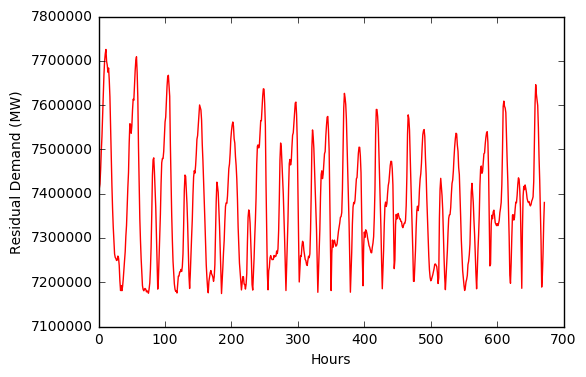

In [39]:
# Calculate the hourly operating cost of the facility    
operating_cost_indiv = np.matlib.zeros((len(hours), len(num_gen)))
operating_cost_hourly = np.matlib.zeros((len(hours), 1))

for hour in hours:
    for i in num_gen:
        operating_cost_indiv[hour, i] = ((fixed_cost[i]+capital_cost[i]+fixed_cost_ops[i])*(max(hours)/8760)*(capacity[i])*1000) + (variable_cost[i]*power_out[hour, i])       


# Calculate the hourly breakdown of the energy cost
energy_cost_indiv = np.matlib.zeros((len(hours), len(num_gen)))
energy_cost_hourly = np.matlib.zeros((len(hours), 1))

for hour in hours:
    for i in num_gen:
        energy_cost_indiv[hour, i] = (no_load_heat[i] * fuel_cost[i] * unit_com[hour, i]) + (incr_heat_rate[i] * 1000 * power_out[hour, i])

# Calculate the hourly breakdown of startup costs
startup_cost_indiv = np.matlib.zeros((len(hours), len(num_gen)))
startup_cost_hourly = np.matlib.zeros((len(hours), 1))        
     
for hour in hour_range:
    for i in num_gen:
        startup_cost_indiv[hour, i] = (startup_fixed[i] * (unit_com[hour, i] - unit_com[hour - 1, i])) + (startup_heat[i] * fuel_cost[i] * (unit_com[hour, i] - unit_com[hour - 1, i]))
        
totalsystemcost_hourly = np.matlib.zeros((len(hours), 1))       

# operating_cost_hourly = operating_cost_indiv.sum(axis = 1)
# energy_cost_hourly = energy_cost_indiv.sum(axis = 1)
# startup_cost_hourly = startup_cost_indiv.sum(axis = 1)

for hour in hours:        
    for i in num_gen:
        operating_cost_hourly[hour] = operating_cost_indiv[hour, i] + operating_cost_hourly[hour]
        energy_cost_hourly[hour] = energy_cost_indiv[hour, i] + energy_cost_hourly[hour] 
        startup_cost_hourly[hour] = startup_cost_indiv[hour, i] + startup_cost_hourly[hour]
    
for hour in hours:    
    totalsystemcost_hourly[hour] = (operating_cost_hourly[hour] + energy_cost_hourly[hour] + startup_cost_hourly[hour])/total_gen[hour] 
     
       
        
productioncost = quicksum(totalsystemcost_hourly[hour] for hour in hours)

obj = productioncost 

model.setObjective(obj, GRB.MINIMIZE)
        
plt.figure()
plt.plot(hours, totalsystemcost_hourly, 'r')
plt.xlabel('Hours')
plt.ylabel('Residual Demand (MW)')
plt.show()

In [47]:
# Set the objective function

# Calculate the production cost of the facility
# energy_cost = quicksum(quicksum((no_load_heat[i] * fuel_cost[i] * v[hour, i]) for i in num_gen) for hour in hours) + quicksum(quicksum(incr_heat_rate[i] * 1000 * p[hour, i] for i in num_gen) for hour in hours)                                                                                                                 

# Calculate the operating cost of the facility                                                                                                              
# operating_cost = quicksum(quicksum((((fixed_cost[i]+capital_cost[i]+fixed_cost_ops[i])*((max(hours))/8760)*(capacity[i]*1000)) for i in num_gen)) for hour in hours) + quicksum(quicksum(variable_cost[i]*p[hour, i] for hour in hours) for i in num_gen)
# hour_range = range(1, max(hours))

# Calculate the shut down cost based on the number of shut-downs the facility goes through
# shutdowncost = quicksum(quicksum(shutdown_cost[i] * (v[hour -1, i] - v[hour, i]) for i in num_gen) for hour in hour_range)

# startup_variable = np.matlib.zeros((len(hours), len(num_gen)))
# shutdown_variable = np.matlib.zeros((len(hours), len(num_gen)))

# for hour in hours:
#     for i in num_gen:
#         startup_variable[hour, i] = max((v[hour, i] - v[hour - 1, i]), 0)
#         shutdown_variable[hour, i] = max((v[hour -1, i] - v[hour, i]), 0)


# Calculate the start up cost of the facility
# startupcost = quicksum(quicksum(startup_fixed[i] * (v[hour, i] - v[hour - 1, i]) for hour in hour_range) for i in num_gen) + quicksum(quicksum(startup_heat[i] * fuel_cost[i] * (v[hour, i] - v[hour - 1, i]) for i in num_gen) for hour in hour_range)
# startupcost = quicksum(quicksum(startup_fixed[i] * startup_variable[hour, i] for hour in hour_range) for i in num_gen) + quicksum(quicksum(startup_heat[i] * fuel_cost[i] * startup_variable[hour, i] for i in num_gen) for hour in hour_range)





KeyError: (-1, 0)

In [ ]:
# Run the optimisation code

model.Params.timeLimit = 100.0
model.optimize()
status = model.status  


In [33]:
# Compute IIS if necessary

# if status != GRB.Status.OPTIMAL:
#     model.computeIIS()
#     model.write("model.ilp")

status

9

In [34]:
# Output Results if necessary

if status == 2 or 9:
    sol_p = model.getAttr("X", p)
    sol_v = model.getAttr("X", v)
    sol_p_upper = model.getAttr("X", p_upper)
    sol_charging = model.getAttr("X",charge)
    sol_discharging = model.getAttr("X",discharge)
    sol_batt_level = model.getAttr("X",energy)
    sol_charge_up = model.getAttr("X",charge_status)
    sol_discharge_up = model.getAttr("X",discharge_status)
    sol_new_capacity = model.getAttr("X", new_capacity)
    print('Optimization status was %d' % status)
    print('The optimal objective is %g' % model.objVal)



Optimization status was 9
The optimal objective is 1.78568e+14


# Post Process

## Graphs

### Data processing

In [35]:
# gen_type_summary is the variable that stores all of the clustered results (when using the unclustered data - i.e all
# individual generators - i.e when cluster == 0)
gen_type_summary = np.zeros((len(num_types), len(hours)))

power_stack = np.zeros((len(num_types), len(hours)))

# Each of these variables stores the results from the model - this needs to be checked to figure out if it needs to be this way
# i.e are there other ways of just using the output variables?

power_out = np.matlib.zeros((len(hours), len(max_power_out)))

unit_com = np.matlib.zeros((len(hours), len(max_power_out)))

power_upper_res = np.matlib.zeros((len(hours), len(max_power_out)))

total_gen = np.matlib.zeros((len(hours), 1))

total_res = np.matlib.zeros((len(hours), 1))

totalMWh = np.matlib.zeros((len(num_gen),1))

totalhours = np.matlib.zeros((len(num_gen),1))

loadfactor = np.matlib.zeros((len(hours), len(num_gen)))

avgloadfactor = np.matlib.zeros((len(num_gen),1))

utility =  np.matlib.zeros((len(num_gen),1))

discharging = np.matlib.zeros((len(hours), len(num_gen)))

charging = np.matlib.zeros((len(hours), len(num_gen)))

charge_up = np.matlib.zeros((len(hours), len(num_gen)))

discharge_up = np.matlib.zeros((len(hours), len(num_gen)))

batt_level = np.matlib.zeros((len(hours), len(num_gen)))

new_install = np.matlib.zeros((len(num_gen),1))

for hour in hours:
    for i in num_gen:
        power_out[hour, i] = sol_p[hour,i]
        unit_com[hour, i] = sol_v[hour,i]
        power_upper_res[hour, i] = sol_p_upper[hour, i]
        discharging[hour, i] = sol_discharging[hour, i]
        charging[hour, i] = sol_charging[hour, i]
        batt_level[hour, i] = sol_batt_level[hour, i]
        charge_up[hour, i] = sol_charge_up[hour, i]
        discharge_up[hour, i] = sol_discharge_up[hour, i]     

        
        
total_gen = numpy.sum(power_out, axis=1)
total_res = numpy.sum(power_upper_res, axis=1)

# Process the data for each individual generator
for i in num_gen:
    for hour in hours:
        loadfactor[hour, i] = power_out[hour, i] / max_power_out[i]
    loadfactor = numpy.nan_to_num(loadfactor) 
    totalMWh[i] = sum(power_out[:,i])
    totalhours[i] = sum(unit_com[:, i])
    avgloadfactor[i] = sum(loadfactor[:, i]) / totalhours[i]
    avgloadfactor = numpy.nan_to_num(avgloadfactor) 
    utility[i] = totalhours[i]/len(hours)
    new_install[i] = sol_new_capacity[i]
    
# Process the data in terms of the generating types
# This code is for the unclustered set
if cluster == 0:
    for i in num_gen:
        for x in num_labels:
                a = gen_type[i]
                b = gen_label[x]
                if a in b:
                    gen_type_summary[x,:] = gen_type_summary[x,:] + np.transpose(power_out[:,i])
                    
                
              
# This code is for the clustered set 
if cluster == 1:
    for i in num_types:
        power_stack[i,:] = np.transpose(power_out[:,i])

        

### Output Power from each generator

In [ ]:
plot_dim = math.ceil((max(num_gen)+1)/3)
fig, axs = plt.subplots(plot_dim, 3, figsize=(10, 20))
fig.subplots_adjust(hspace = 2 , wspace=.5)

axs = axs.ravel()

for x in num_gen:

    axs[x].plot(hours, power_out[:,x])
    axs[x].set_title(str(x))
    axs[x].set_xlim([0, max(hours)])
    axs[x].set_ylim([-10, max(power_out[:,x]) + 10])
    
fig.savefig('genoutput.png')   # save the figure to file
plt.close(fig)  


### Switching status of each generator

In [ ]:
plot_dim = math.ceil((max(num_gen)+1)/3)
fig, axs = plt.subplots(plot_dim, 3, figsize=(10, 9))
fig.subplots_adjust(hspace = .5, wspace=.01)

axs = axs.ravel()

for x in num_gen:

    axs[x].step(hours, unit_com[:,x])
    axs[x].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axs[x].set_xlim([0, max(hours)])
    axs[x].set_ylim([-0.5, 1.5])
    axs[x].axes.get_yaxis().set_visible(False)
    
    
fig.savefig('switchingstatus.png')   # save the figure to file
plt.close(fig)  
    

### Stacked Plot

In [ ]:
if cluster == 1:
    # Generate subplot for the period of all committed generators
    fig, ax = plt.subplots()
    for i in num_types:
        ax.stackplot(hours, power_stack[i,:])
   
    plt.legend(gen_label, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Hours')
    plt.ylabel('Dispatch Level (MW)')
    plt.show()
    
else:
    fig, ax = plt.subplots()
    for i in num_labels:
        ax.stackplot(hours,  gen_type_summary[i,:])
   
    plt.legend(gen_label, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Hours')
    plt.ylabel('Dispatch Level (MW)')
    plt.show()
    
#fig.savefig('stackplot.png')   # save the figure to file
#plt.close(fig)  

In [ ]:
t1 = time.time()

total = t1-t0

print(total)


